In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
iris = pd.read_excel("iris.xlsx")

In [3]:
iris = iris.sort_index()

In [4]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,iris_setosa
1,4.9,3.0,1.4,0.2,iris_setosa
2,4.7,3.2,1.3,0.2,iris_setosa
3,4.6,3.1,1.5,0.2,iris_setosa
4,5.0,3.6,1.4,0.2,iris_setosa


In [5]:
iris.isna().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

In [6]:
print(iris.shape)

(150, 5)


In [7]:
print(iris['species'].unique())

['iris_setosa' 'iris_versicolour' 'iris _virginica']


In [8]:
print(iris.groupby('species').size())

species
iris _virginica     50
iris_setosa         50
iris_versicolour    50
dtype: int64


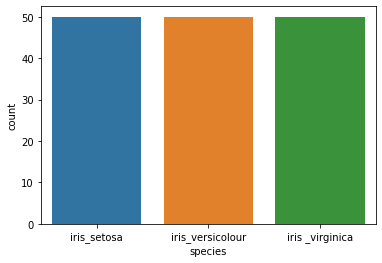

In [9]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import seaborn as sns
sns.countplot(iris['species'],label="Count")
plt.show()

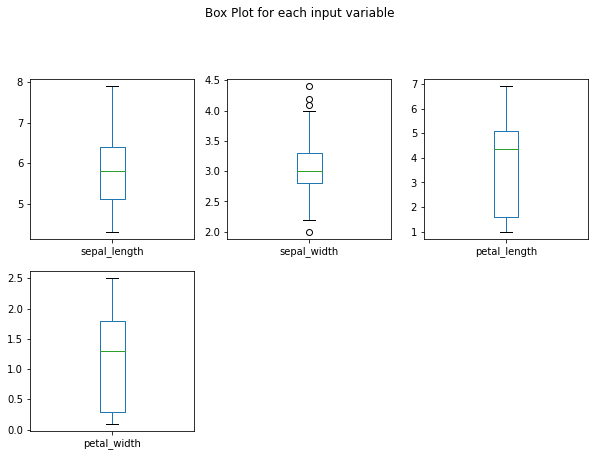

In [10]:
iris.drop('species', axis=1).plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(10,10), 
                                        title='Box Plot for each input variable')
plt.savefig('species_box')
plt.show()

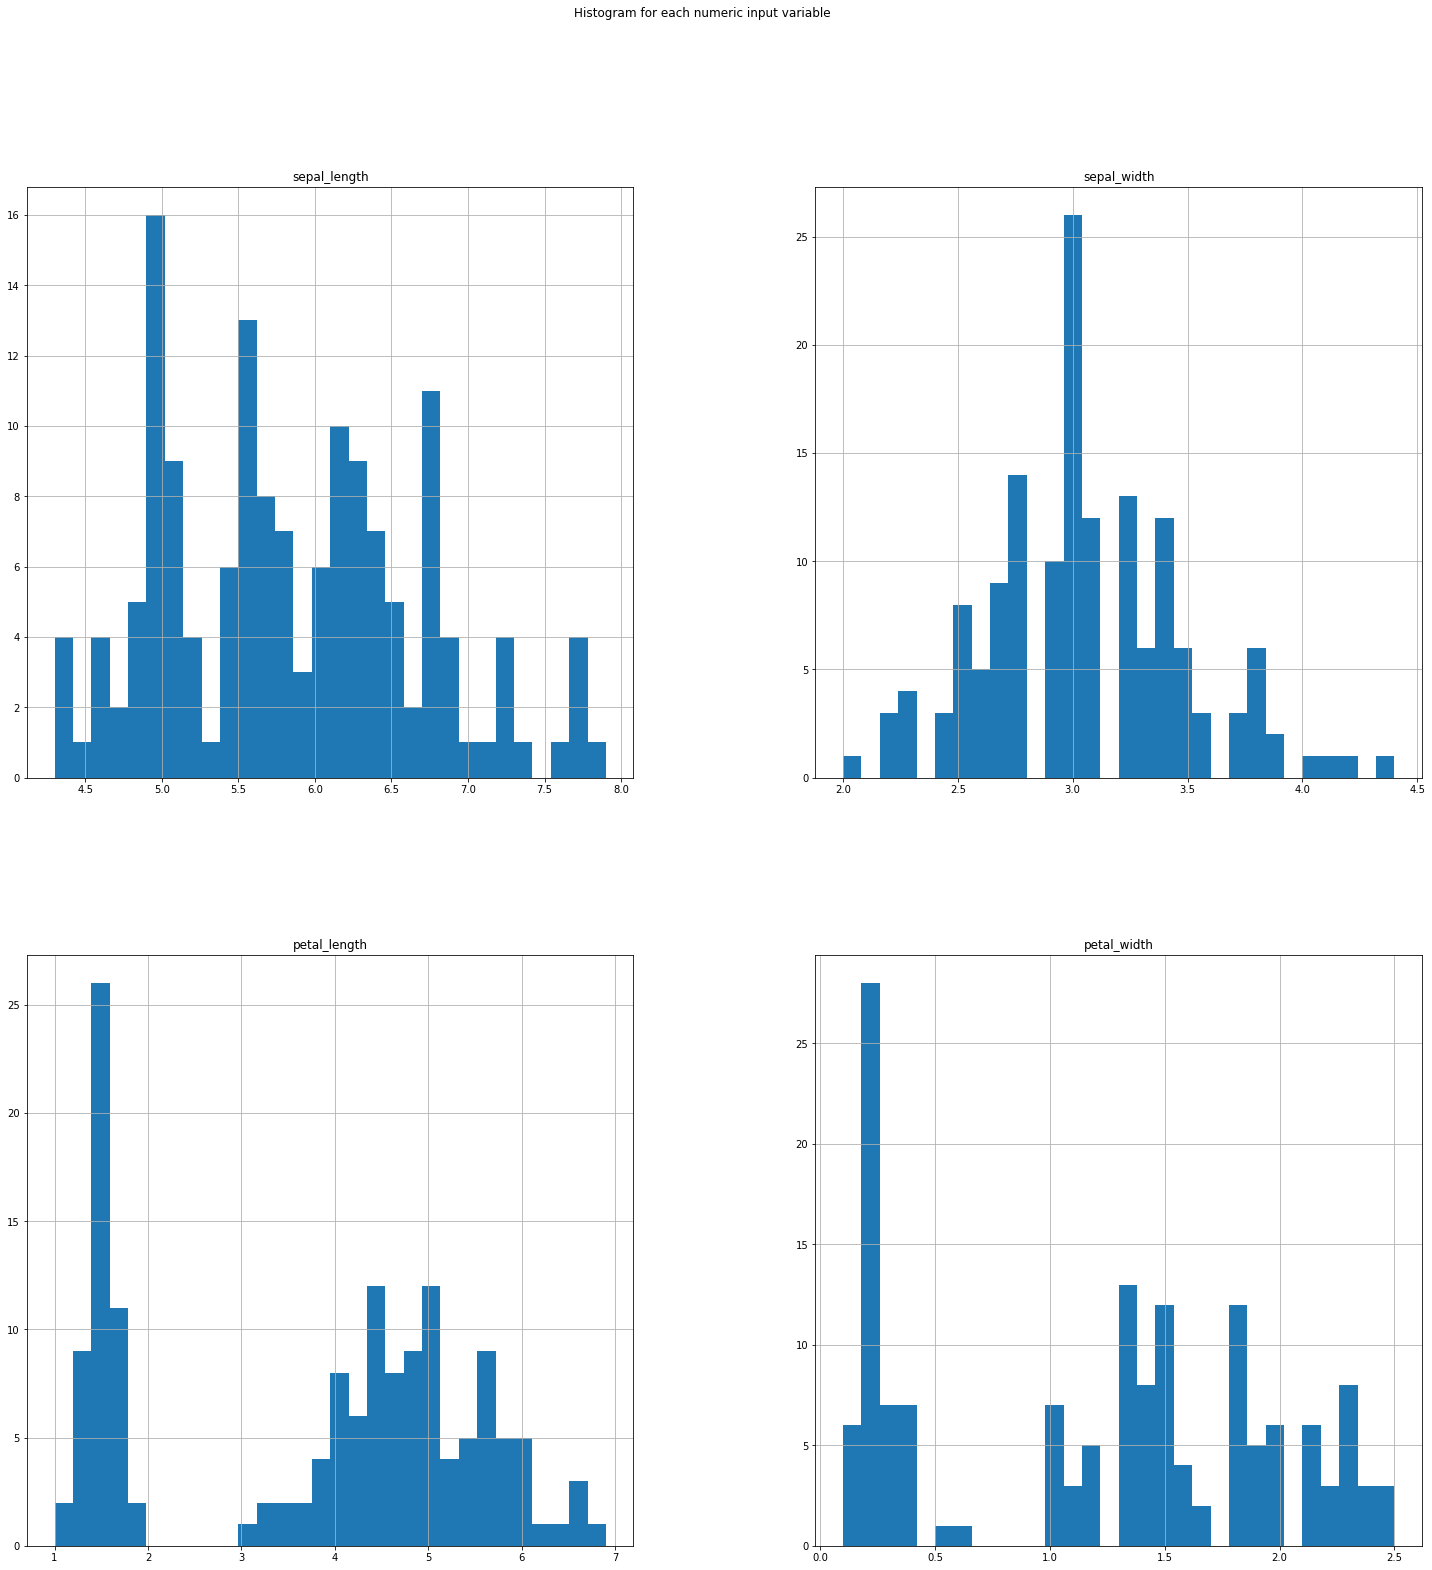

In [11]:
import pylab as pl
iris.drop('species' ,axis=1).hist(bins=30, figsize=(25,25))
pl.suptitle("Histogram for each numeric input variable")
plt.savefig('species_hist')
plt.show()

In [12]:
from pandas.plotting import scatter_matrix
from matplotlib import cm
import numpy as np

In [13]:
feature_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
X = iris[feature_names]
y = iris['species']

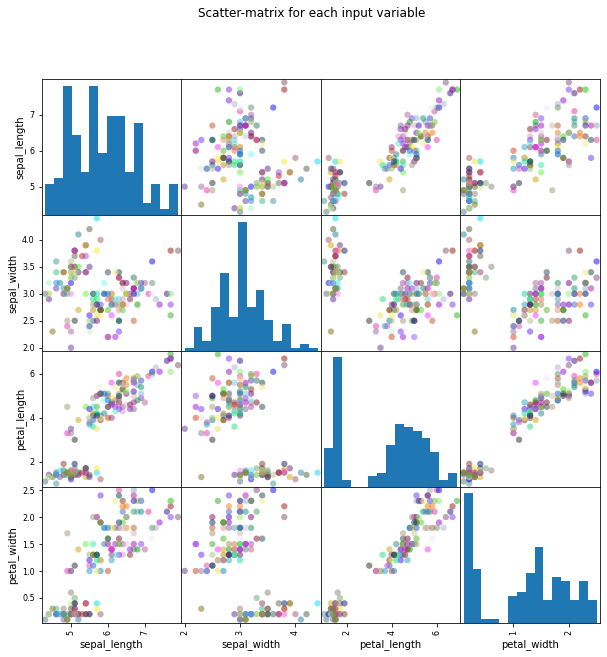

In [14]:
cmap = cm.get_cmap('gnuplot')
scatter = scatter_matrix(X, c = np.random.rand(len(y),4), marker = 'o', s=40, hist_kwds={'bins':15}, figsize=(10,10), cmap = cmap)
plt.suptitle('Scatter-matrix for each input variable')
plt.savefig('iris_scatter_matrix')

In [15]:
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [16]:
from sklearn import preprocessing
encode = preprocessing.LabelEncoder()
iris.species = encode.fit_transform(iris.species)
list(encode.inverse_transform([0,1,2]))

['iris _virginica', 'iris_setosa', 'iris_versicolour']

# Firefly Algorithm

In [29]:
import numpy
import math
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold,cross_val_score
        
def alpha_new(alpha, NGen):
    #% alpha_n=alpha_0(1-delta)^NGen=10^(-4);
    #% alpha_0=0.9
    delta = 1 - (10 ** (-4) / 0.9) ** (1 / NGen)
    alpha = (1 - delta) * alpha
    return alpha


def FFA(X_train,X_test,y_train,y_test, lb, ub, dim, n, MaxGeneration):

    # General parameters

    # n=50 #number of fireflies
    # dim=30 #dim
    # lb=-50
    # ub=50
    # MaxGeneration=10

    # FFA parameters
    alpha = 0.5  # Randomness 0--1 (highly random)
    betamin = 0.20  # minimum value of beta
    gamma = 1  # Absorption coefficient
    if not isinstance(lb, list):
        lb = [lb] * dim
    if not isinstance(ub, list):
        ub = [ub] * dim

    zn = numpy.ones(n)
    zn.fill(float("inf"))

    #ns(i,:)=Lb+(Ub-Lb).*rand(1,d);
    ns = numpy.zeros((n, dim))
    for i in range(dim):
        ns[:, i] = numpy.random.uniform(0, 1, n) * (ub[i] - lb[i]) + lb[i]
    Lightn = numpy.ones(n)
    Lightn.fill(float("inf"))

    #[ns,Lightn]=init_ffa(n,d,Lb,Ub,u0)
    
    convergence = []
    iterations = []
    accuracy = []
    array = []
    
    # Main loop
    t = 0 
    while t < MaxGeneration:
        for k in range(0, MaxGeneration):  #start iterations

            #This line of reducing alpha is optional
            alpha = alpha_new(alpha, MaxGeneration)
        
            kmeans = KMeans(n_clusters = i).fit(X_train,y_train)
            cv = KFold(n_splits = 10, shuffle = True, random_state = 15)
            cv_accuracies = cross_val_score(kmeans,  X_test, y_test, cv = cv,scoring = 'accuracy')


            accuracies = cv_accuracies.mean()            
            fitness_value = (1 - accuracies) * 100
            
            
            #Evaluate new solutions (for all n fireflies)
            for i in range(0, n):
                zn[i] = kmeans.predict(ns[i, :].reshape(1,-1))
                Lightn[i] = zn[i]

            #Ranking fireflies by their light intensity/objectives

            Lightn = numpy.sort(zn)
            Index = numpy.argsort(zn)
            ns = ns[Index, :]

            #Find the current best
            nso = ns
            Lighto = Lightn
            nbest = ns[0, :]
            Lightbest = Lightn[0]

            #% For output only
            fbest = Lightbest
            convergence.append(fbest)
            array.append((100-fbest)/100)

            #Move all fireflies to the better locations
            #  [ns]=ffa_move(n,d,ns,Lightn,nso,Lighto,nbest,...
            #    Lightbest,alpha,betamin,gamma,Lb,Ub);
            scale = []
            for b in range(dim):
                scale.append(abs(ub[b] - lb[b]))
            scale = numpy.array(scale)
            for i in range(0, n):
                #The attractiveness parameter beta=exp(-gamma*r)
                for j in range(0, n):
                    r = numpy.sqrt(numpy.sum((ns[i, :] - ns[j, :]) ** 2))
                    #r=1
                    #Update moves
                    if Lightn[i] > Lighto[j]:  #Brighter and more attractive
                        beta0 = 1
                        beta = (beta0 - betamin) * math.exp(-gamma * r ** 2) + betamin
                        tmpf = alpha * (numpy.random.rand(dim) - 0.5) * scale
                        ns[i, :] = ns[i, :] * (1 - beta) + nso[j, :] * beta + tmpf

        #ns=numpy.clip(ns, lb, ub)
        t = t + 1
        iterations.append(t)
        accuracy.append((100-fbest)/100)
        

        IterationNumber = k
        BestQuality = fbest

        #if IterationNumber % 1 == 0:
        #print(["At iteration " + str(k) + " the best fitness is " + str(BestQuality)])
        #print('accuracy:',((100 - fbest) / 100))
        
        newArray = []
        newArray = array

        from sorting_techniques import pysort
        sortObj = pysort.Sorting()
        sortResult = sortObj.bubbleSort(newArray)

        print(sortResult) 
        
        if array[k] == sortResult[-1]:

            print("At iteration is: " + str(k+1) , "the best fitness is " + str(BestQuality))
            print('accuracy:',sortResult[-1])
            break 
        else:
            print(array[k], sortResult[-1])

    return IterationNumber,BestQuality,sortResult[-1]
    
    ####################### End main loop ##########################


# Kmeans

In [30]:
X = iris.drop('species',axis = 1)
y = iris.species

In [31]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [32]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test= train_test_split(X, y, test_size = 0.5, random_state = 0)

In [33]:
IterationNumber,BestQuality,accuracy = FFA(X_train,X_test,y_train,y_test,-50,50,4,50,10)

[0.67, 0.72, 0.74, 0.76, 0.81, 0.91, 0.92, 0.97, 0.97, 1.0]
At iteration is: 10 the best fitness is 19.0
accuracy: 1.0


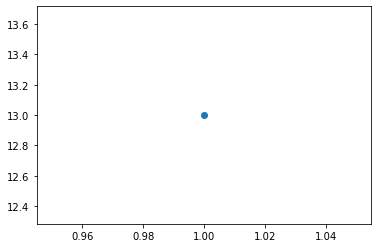

In [22]:
import matplotlib.pyplot as plt
plt.scatter(accuracy,BestQuality)

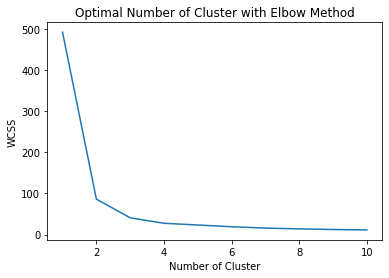

In [23]:
import warnings
warnings.simplefilter(action="ignore", category=UserWarning)

X = iris.iloc[:,[1,2]].values
from sklearn.cluster import KMeans
wcss = []
number_of_cluster_list = range(1, 11)
for i in number_of_cluster_list :
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(number_of_cluster_list, wcss)
plt.title('Optimal Number of Cluster with Elbow Method')
plt.xlabel('Number of Cluster')
plt.ylabel('WCSS')
plt.show()

In [24]:
#n_clusters = 3 
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(X)
print([y_kmeans])

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1])]


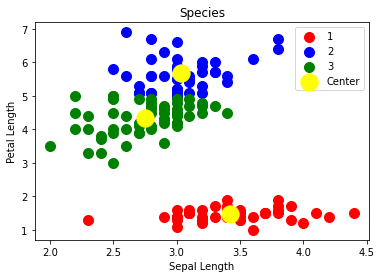

In [25]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = '1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = '2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = '3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Center')
plt.title('Species')
plt.xlabel('Sepal Length')
plt.ylabel('Petal Length')
plt.legend()
plt.show()

In [26]:
kmeans = KMeans(n_clusters = i).fit(X_train,y_train)
y_pred = kmeans.predict(X_train)

In [27]:
cv = KFold(n_splits = 10, shuffle = True, random_state = 30)
accuracies = cross_val_score(kmeans, X , y , cv = cv)
accuracy_mean = accuracies.mean()
print(accuracy_mean)
accuracy_std = accuracies.std() * 100
print(accuracy_std)

-1.5880065716022558
45.30967623824638


In [28]:
from sklearn.metrics import confusion_matrix
error_matrix = confusion_matrix(y_train, y_pred)
print(error_matrix)

[[ 5  0  6  1  0  0  0 11  0  3]
 [ 0 11  0  0  1 11  0  0  6  0]
 [ 6  0  0  4  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
